In [2]:
import random
import pandas as pd
from datetime import datetime, timedelta


def generate_synthetic_record():
    sim_swap_time_gap_minutes = random.randint(0, 10080)  # up to 7 days
    device_change_flag = random.choice([0, 1])
    sim_type_change_flag = random.choice([0, 1])
    imsi_change_flag = random.choice([0, 1])
    iccid_change_flag = random.choice([0, 1])
    otp_and_sim_change_geo_hash_length = round(random.uniform(0.0, 1.0), 2)

    # New features
    recent_sim_activation_days = random.randint(0, 365)
    num_sim_changes_last_30d = random.randint(0, 5)
    previous_sim_holder_tenure_days = random.randint(0, 1095)  # Up to 3 years
    account_age_days = random.randint(1, 1825)  # Up to 5 years
    ip_change_flag = random.choice([0, 1])

    # Sim swap flag logic (simple heuristic)
    identity_shift_score = device_change_flag + sim_type_change_flag + imsi_change_flag + iccid_change_flag
    geo_risk_score = 1 - otp_and_sim_change_geo_hash_length
    time_urgency_score = 1 - min(sim_swap_time_gap_minutes, 10080) / 10080

    fraud_score = (
            0.3 * identity_shift_score +
            0.2 * geo_risk_score +
            0.2 * time_urgency_score +
            0.1 * (1 if recent_sim_activation_days < 7 else 0) +
            0.1 * (1 if num_sim_changes_last_30d >= 2 else 0) +
            0.1 * ip_change_flag
    )
    sim_swap_flag = 1 if fraud_score > 0.7 else 0

    return {
        "sim_swap_time_gap_minutes": sim_swap_time_gap_minutes,
        "device_change_flag": device_change_flag,
        "sim_type_change_flag": sim_type_change_flag,
        "imsi_change_flag": imsi_change_flag,
        "iccid_change_flag": iccid_change_flag,
        "otp_and_sim_change_geo_hash_length": otp_and_sim_change_geo_hash_length,
        "recent_sim_activation_days": recent_sim_activation_days,
        "num_sim_changes_last_30d": num_sim_changes_last_30d,
        "previous_sim_holder_tenure_days": previous_sim_holder_tenure_days,
        "account_age_days": account_age_days,
        "ip_change_flag": ip_change_flag,
        "sim_swap_flag": sim_swap_flag
    }


def generate_dataset(n=10000):
    return pd.DataFrame([generate_synthetic_record() for _ in range(n)])


if __name__ == "__main__":
    df = generate_dataset(10000)
    df.to_csv("sim_swap_fraud_dataset_10000.csv", index=False)
    print("Dataset with 10,000 records saved as 'sim_swap_fraud_dataset_10000.csv'")


Dataset with 10,000 records saved as 'sim_swap_fraud_dataset_10000.csv'


In [12]:
import pandas as pd

# Load the labeled dataset (with 'sim_swap_flag')
df_raw = pd.read_csv("sim_swap_fraud_dataset_10000.csv")

# Preview the dataset
df_raw.head()

,sim_swap_time_gap_minutes,device_change_flag,sim_type_change_flag,imsi_change_flag,iccid_change_flag,otp_and_sim_change_geo_hash_length,recent_sim_activation_days,num_sim_changes_last_30d,previous_sim_holder_tenure_days,account_age_days,ip_change_flag,sim_swap_flag
0,9424,0,1,0,0,0.48,272,2,1059,251,1,0
1,7845,1,0,0,0,0.94,297,1,522,485,0,0
2,6157,0,0,1,1,0.41,170,3,1080,1809,1,1
3,801,0,0,1,0,0.10,182,0,391,612,0,0
4,4166,0,1,1,1,0.98,112,2,314,1534,0,1


In [13]:
# Re-import necessary libraries (if needed)
import pandas as pd

# Load the original dataset
df_raw = pd.read_csv("sim_swap_fraud_dataset_50000.csv")

# Define enrichment function
def enrich_input(raw):
    enriched = raw.copy()

    # Derived features
    enriched['time_urgency_score'] = 1 - min(raw['sim_swap_time_gap_minutes'], 10080) / 10080
    enriched['identity_shift_score'] = sum([
        raw['device_change_flag'],
        raw['sim_type_change_flag'],
        raw['imsi_change_flag'],
        raw['iccid_change_flag']
    ])
    enriched['geo_risk_score'] = 1 - raw['otp_and_sim_change_geo_hash_length']

    # New enrichment based on additional features
    enriched['sim_activity_score'] = 1 - min(raw['recent_sim_activation_days'], 365) / 365
    enriched['account_risk_score'] = (
        raw['num_sim_changes_last_30d'] * 0.3 +
        (1 - min(raw['previous_sim_holder_tenure_days'], 3650) / 3650) * 0.3 +
        (1 - min(raw['account_age_days'], 3650) / 3650) * 0.3 +
        raw['ip_change_flag'] * 0.1
    )

    return enriched

# Apply enrichment to all rows
df_enriched = df_raw.apply(enrich_input, axis=1)

# Confirm new columns exist
df_enriched.head()


,sim_swap_time_gap_minutes,device_change_flag,sim_type_change_flag,imsi_change_flag,iccid_change_flag,otp_and_sim_change_geo_hash_length,recent_sim_activation_days,num_sim_changes_last_30d,previous_sim_holder_tenure_days,account_age_days,ip_change_flag,sim_swap_flag,time_urgency_score,identity_shift_score,geo_risk_score,sim_activity_score,account_risk_score
0,8737.0,1.0,1.0,1.0,1.0,0.75,47.0,1.0,342.0,619.0,1.0,1.0,0.133234,4.0,0.25,0.871233,0.921014
1,7396.0,0.0,1.0,1.0,0.0,0.04,277.0,3.0,409.0,1441.0,0.0,1.0,0.266270,2.0,0.96,0.241096,1.347945
2,2610.0,0.0,0.0,0.0,1.0,0.71,311.0,4.0,631.0,407.0,1.0,1.0,0.741071,1.0,0.29,0.147945,1.814685
3,8266.0,0.0,1.0,1.0,1.0,0.74,274.0,4.0,432.0,642.0,0.0,1.0,0.179960,3.0,0.26,0.249315,1.711726
4,5051.0,1.0,0.0,1.0,0.0,0.74,128.0,4.0,313.0,616.0,0.0,1.0,0.498909,2.0,0.26,0.649315,1.723644


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Features and label
feature_columns = [
    "sim_swap_time_gap_minutes",
    "device_change_flag",
    "sim_type_change_flag",
    "imsi_change_flag",
    "iccid_change_flag",
    "otp_and_sim_change_geo_hash_length",
    "recent_sim_activation_days",
    "num_sim_changes_last_30d",
    "previous_sim_holder_tenure_days",
    "account_age_days",
    "ip_change_flag"
]
label_column = "sim_swap_flag"

X = df_enriched[feature_columns]
y = df_enriched[label_column]

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print("Model trained successfully!")


Model trained successfully!


In [17]:
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions on the test set
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of class 1 (fraud)
y_pred_class = model.predict(X_test)

# Helper function to convert probability to risk level
def classify_risk(prob):
    if prob >= 0.9:
        return "Very High"
    elif prob >= 0.7:
        return "High"
    elif prob >= 0.4:
        return "Medium"
    elif prob >= 0.2:
        return "Low"
    else:
        return "Very Low"

# Apply risk classification
risk_levels = [classify_risk(p) for p in y_pred_proba]

# Create results DataFrame
results_df = X_test.copy()
results_df['Actual_Label'] = y_test.values
results_df['Predicted_Label'] = y_pred_class
results_df['Fraud_Probability'] = y_pred_proba
results_df['Risk_Level'] = risk_levels

# Show sample predictions
results_df.head(10)


,sim_swap_time_gap_minutes,device_change_flag,sim_type_change_flag,imsi_change_flag,iccid_change_flag,otp_and_sim_change_geo_hash_length,recent_sim_activation_days,num_sim_changes_last_30d,previous_sim_holder_tenure_days,account_age_days,ip_change_flag,Actual_Label,Predicted_Label,Fraud_Probability,Risk_Level
1227,6003.0,1.0,0.0,0.0,1.0,0.07,310.0,5.0,1062.0,1276.0,0.0,1.0,1.0,0.99,Very High
26043,1725.0,0.0,1.0,0.0,0.0,0.08,44.0,5.0,413.0,1165.0,0.0,1.0,1.0,0.89,High
34455,5294.0,0.0,1.0,0.0,1.0,0.20,8.0,2.0,634.0,1223.0,0.0,1.0,1.0,1.00,Very High
18713,9590.0,1.0,0.0,1.0,1.0,0.57,263.0,3.0,355.0,1569.0,1.0,1.0,1.0,0.99,Very High
37631,4356.0,1.0,1.0,0.0,1.0,0.13,65.0,1.0,948.0,781.0,1.0,1.0,1.0,1.00,Very High
48069,7111.0,1.0,0.0,1.0,1.0,0.77,89.0,2.0,641.0,1205.0,1.0,1.0,1.0,1.00,Very High
42738,4474.0,0.0,0.0,0.0,1.0,0.07,122.0,3.0,795.0,1577.0,1.0,1.0,1.0,0.96,Very High
46091,2476.0,0.0,0.0,0.0,0.0,0.40,237.0,1.0,230.0,462.0,0.0,0.0,0.0,0.01,Very Low
54,7043.0,1.0,0.0,0.0,1.0,0.39,360.0,5.0,1095.0,1711.0,0.0,1.0,1.0,0.97,Very High
47377,8444.0,0.0,1.0,0.0,0.0,0.37,70.0,1.0,276.0,547.0,0.0,0.0,0.0,0.00,Very Low


Evaluate Model Performance

Let’s look at the performance metrics like accuracy, precision, recall, and F1 score, along with the confusion matrix:

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

# Classification report
print("📊 Classification Report:")
print(classification_report(y_test, y_pred_class, digits=4))

# Confusion matrix
print("🧮 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_class))

📊 Classification Report:
              precision    recall  f1-score   support

         0.0     0.9823    0.9841    0.9832      2647
         1.0     0.9943    0.9936    0.9939      7353

    accuracy                         0.9911     10000
   macro avg     0.9883    0.9889    0.9886     10000
weighted avg     0.9911    0.9911    0.9911     10000

🧮 Confusion Matrix:
[[2605   42]
 [  47 7306]]


Visualize Risk Level Distribution

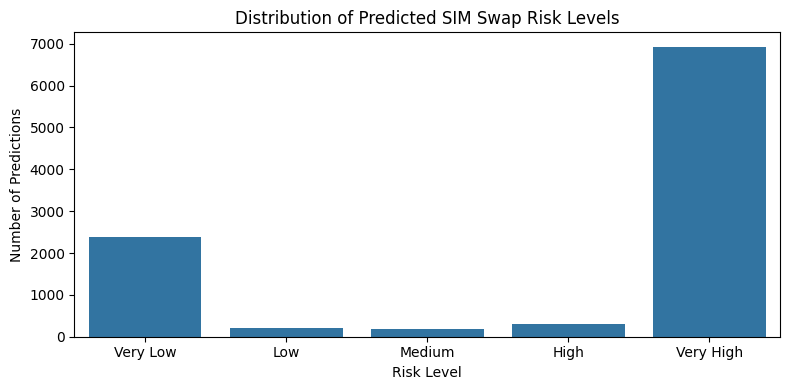

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.countplot(data=results_df, x="Risk_Level", order=["Very Low", "Low", "Medium", "High", "Very High"])
plt.title("Distribution of Predicted SIM Swap Risk Levels")
plt.xlabel("Risk Level")
plt.ylabel("Number of Predictions")
plt.tight_layout()
plt.show()


In [20]:
import joblib

# Save the trained model
joblib.dump(model, "sim_swap_fraud_rf_model.pkl")
print("✅ Model saved to sim_swap_fraud_rf_model.pkl")


✅ Model saved to sim_swap_fraud_rf_model.pkl


In [27]:
# Define a single raw input
custom_input = {
    "sim_swap_time_gap_minutes": 300,
    "device_change_flag": 1,
    "sim_type_change_flag": 0,
    "imsi_change_flag": 0,
    "iccid_change_flag": 0,
    "otp_and_sim_change_geo_hash_length": 0.2,
    "recent_sim_activation_days": 0,
    "num_sim_changes_last_30d": 0,
    "previous_sim_holder_tenure_days": 30,
    "account_age_days": 200,
    "ip_change_flag": 1
}

# Enrich the input
enriched_input = enrich_input(custom_input)
input_df = pd.DataFrame([enriched_input])

# Ensure input has the correct feature order
input_features = input_df[feature_columns]

# Predict using trained model
pred_proba = model.predict_proba(input_features)[0][1]  # Probability of fraud
pred_class = model.predict(input_features)[0]

# Map probability to risk level
def map_risk_level(prob):
    if prob >= 0.90:
        return "Very High"
    elif prob >= 0.70:
        return "High"
    elif prob >= 0.40:
        return "Medium"
    elif prob >= 0.20:
        return "Low"
    else:
        return "Very Low"

risk_level = map_risk_level(pred_proba)

# Show results
print(f"🔍 Predicted Fraud Probability: {pred_proba:.4f}")
print(f"🔒 Classified as: {risk_level} Risk")
print(f"📌 Model Binary Class Prediction: {pred_class} (1 = Fraud, 0 = Normal)")


🔍 Predicted Fraud Probability: 0.8400
🔒 Classified as: High Risk
📌 Model Binary Class Prediction: 1.0 (1 = Fraud, 0 = Normal)
